# Tomato Leaf Detection using Transfer Learning VGG16

## Import Libraries

In [114]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
import cv2
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt

## Resize the Image

In [3]:
IMAGE_SIZE = [224, 224]

train_path = '../input/tomato/New Plant Diseases Dataset(Augmented)/train/*'  # train
valid_path = '../input/tomato/New Plant Diseases Dataset(Augmented)/valid/*'   # test


#### Above we are resizing the image size and taking the path of train and test set

## VGG16 (Transfer Learning)

In [4]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


#### Here we are using VGG16,  we will be using imagenet as a weights and here 3 indicates channel that is RGB, to make it RGB channel we use 3 index
#### we used include_top=False because in VGG16 the output layer has 1000 category, In our case we have only 10 categories.


## Summary of model

In [5]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### As we can see above we have our own input in first layer we are giving our own images and in the last layer we have to add a output layer based on the output category we have.

In [6]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

#### Here we are using existing weights of VGG16 which are initialize, not to retrain them, we will only retrain the last layer, because the last layer have output category that we will use further.

## Glob function

In [7]:
# useful for getting number of output classes
folders = glob('../input/tomato/New Plant Diseases Dataset(Augmented)/train/*')
folders

['../input/tomato/New Plant Diseases Dataset(Augmented)/train/Tomato___Target_Spot',
 '../input/tomato/New Plant Diseases Dataset(Augmented)/train/Tomato___Early_blight',
 '../input/tomato/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy',
 '../input/tomato/New Plant Diseases Dataset(Augmented)/train/Tomato___Leaf_Mold',
 '../input/tomato/New Plant Diseases Dataset(Augmented)/train/Tomato___Late_blight',
 '../input/tomato/New Plant Diseases Dataset(Augmented)/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 '../input/tomato/New Plant Diseases Dataset(Augmented)/train/Tomato___Tomato_mosaic_virus',
 '../input/tomato/New Plant Diseases Dataset(Augmented)/train/Tomato___Spider_mites Two-spotted_spider_mite',
 '../input/tomato/New Plant Diseases Dataset(Augmented)/train/Tomato___Septoria_leaf_spot',
 '../input/tomato/New Plant Diseases Dataset(Augmented)/train/Tomato___Bacterial_spot']

#### Here we have used glob, it indicates the how many number of folder we had means the length of the folder indicates the number of category we have in our neural network.
#### As we can see above, it showing the number of folders are 10, so here our output layer had 10 cateogries.

## Flattening the Output

In [8]:
# output layer - you can add more if you want
x = Flatten()(vgg.output)

#### Here we are adding flatten() method to flattening the output of the convolutional layers to create a single long feature vector. And it is connected to the final classification model, which is called a fully-connected layer. 
#### It convert the 2 dimension into 1 dimension

## Adding Dense Layer as a output 

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)

#### Here we are using len(folders), it indicates that we have 'len(folders)' categories means we have 10 categories because the length of folders is 10. 
#### Activation function we have used is softmax beacause the type of problem is classification.

## Model Creation

In [10]:
# create a model object
model = Model(inputs = vgg.input, outputs = prediction)

#### Here we are creating a model with input layer as vgg.input and output is prediction that is our dense layer with 10 cateories and activation function is softmax.

## Summary of Model

In [11]:
# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

#### As we can see in summary of model we had used dense layer which is our output layer with 3 categories.

## Compiling the Model

In [12]:
# tell the model what cost and optimization method to use
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Here we are compiling our model, our loss function is basically 'categorical_crossentropy' because here our output layer has categories, type of classification problem.

## Data Augmentation

In [13]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

#### Here we are using ImageGenerator for data augmentation, In data augmentation it creates more variation of images or new images by using the existing one.
#### Here ImageGenerator read the images from the folder and apply the data augmentation technique like scaling, zooming, vertical flipping, horizonatal flipping.
#### The model should determine each side of object thats why we use technique like  data augmentation.

#### Above we are rescaling the pixel of an image as we know each pixel ranges between 0 to 255, to convert the pixel between 0 to 1 we are rescaling the pixel.

### Note : We never apply Data Augmentation technique to the test data, because we have to use that original data for predicting our model output.

In [14]:
# Make sure you provide the same target size as initialied for the image size that is (224,224).
training_set = train_datagen.flow_from_directory('../input/tomato/New Plant Diseases Dataset(Augmented)/train', target_size = (224, 224),
                                                 batch_size = 32, class_mode = 'categorical')

Found 18345 images belonging to 10 classes.


In [15]:
test_set = test_datagen.flow_from_directory('../input/tomato/New Plant Diseases Dataset(Augmented)/valid', target_size = (224, 224),
                                            batch_size = 32, class_mode = 'categorical')

Found 4585 images belonging to 10 classes.


#### Here we are reading all the images from the folder. 
#### Target size is (224,224) because we had initiliaze this size in our model, so this should be match.
#### class_ mode is categorical because here we have more then two categories, if we have 2 categoies, we will be using classmode as binary.

## Fitting the Model

In [16]:
# fit the model
# Run the cell. It will take some time to execute
vgg_model = model.fit_generator(training_set, validation_data = test_set, epochs = 10, steps_per_epoch = len(training_set),
  validation_steps = len(test_set))

Epoch 1/10
574/574 [==============================] - 289s 504ms/step - loss: 0.7193 - accuracy: 0.7627 - val_loss: 0.5326 - val_accuracy: 0.8146
Epoch 2/10
574/574 [==============================] - 270s 470ms/step - loss: 0.4337 - accuracy: 0.8560 - val_loss: 0.3438 - val_accuracy: 0.8831
Epoch 3/10
574/574 [==============================] - 265s 461ms/step - loss: 0.3304 - accuracy: 0.8877 - val_loss: 0.6456 - val_accuracy: 0.8061
Epoch 4/10
574/574 [==============================] - 265s 461ms/step - loss: 0.2927 - accuracy: 0.9008 - val_loss: 0.3504 - val_accuracy: 0.8862
Epoch 5/10
574/574 [==============================] - 270s 471ms/step - loss: 0.2735 - accuracy: 0.9092 - val_loss: 0.2839 - val_accuracy: 0.9104
Epoch 6/10
574/574 [==============================] - 281s 489ms/step - loss: 0.2458 - accuracy: 0.9188 - val_loss: 0.5644 - val_accuracy: 0.8417
Epoch 7/10
574/574 [==============================] - 273s 475ms/step - loss: 0.2288 - accuracy: 0.9229 - val_loss: 0.2929 -

#### Our model predicted the amazing training accuracy that is 93 % and validation accuracy is 92 %

## To Check the loss and accuracy of model

In [17]:
vgg_model.history

{'loss': [0.7192605137825012,
  0.4336773753166199,
  0.3303605020046234,
  0.29266172647476196,
  0.2735206186771393,
  0.24583370983600616,
  0.22879555821418762,
  0.22527122497558594,
  0.18935061991214752,
  0.1802566796541214],
 'accuracy': [0.7626601457595825,
  0.8559825420379639,
  0.8876532912254333,
  0.900844931602478,
  0.9091850519180298,
  0.9187789559364319,
  0.9229217767715454,
  0.9268465638160706,
  0.9368219971656799,
  0.9392750263214111],
 'val_loss': [0.5325613021850586,
  0.3438318073749542,
  0.6456114053726196,
  0.3504050076007843,
  0.28390422463417053,
  0.5644111037254333,
  0.2929151952266693,
  0.2651732861995697,
  0.3106900453567505,
  0.2741908133029938],
 'val_accuracy': [0.814612865447998,
  0.8830970525741577,
  0.8061068654060364,
  0.8861504793167114,
  0.9103598594665527,
  0.8416575789451599,
  0.9029443860054016,
  0.9179934859275818,
  0.909051239490509,
  0.9203925728797913]}

#### As we can see above, how loss, val_loss is decreasing and accuracy, val_acc is inreasing. So all these values are saved in dictionary.

## Plot loss and accuracy of model

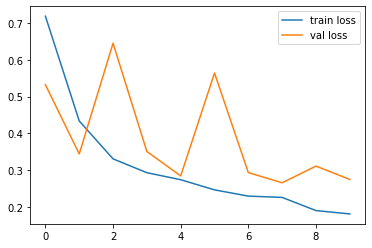

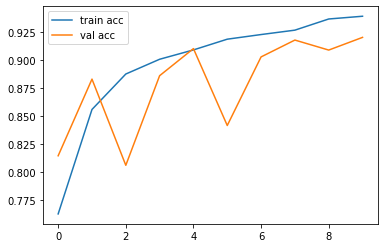

<Figure size 432x288 with 0 Axes>

In [18]:
# plot the loss
plt.plot(vgg_model.history['loss'], label='train loss')
plt.plot(vgg_model.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(vgg_model.history['accuracy'], label='train acc')
plt.plot(vgg_model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

#### As we can see above plot the lines i.e the training accuracy and validation accuracy is going in same direction.

## Save the Model

In [25]:
# save the model  as a h5 file
from tensorflow.keras.models import load_model
model.save('vgg_model.h5')

## Prediction of test data

In [26]:
# prediction of test data
y_pred = model.predict(test_set)
y_pred

array([[6.8479300e-16, 4.9818290e-08, 3.6846926e-10, ..., 3.5066188e-12,
        9.9997008e-01, 1.3364651e-15],
       [5.1716491e-12, 9.9998641e-01, 3.8892963e-06, ..., 1.3132064e-12,
        6.3045881e-19, 5.8522979e-18],
       [5.6313647e-22, 8.7294826e-15, 5.7991481e-12, ..., 1.6842353e-17,
        1.0000000e+00, 1.5479494e-16],
       ...,
       [8.1855367e-10, 1.6821512e-04, 9.9981195e-01, ..., 5.9188904e-12,
        1.5454306e-13, 3.5092681e-16],
       [4.0499753e-16, 5.6563223e-11, 2.1240250e-10, ..., 1.7200720e-13,
        9.9999917e-01, 2.7771641e-11],
       [9.9836808e-01, 2.8363587e-09, 1.1756778e-09, ..., 8.3860513e-10,
        3.8952828e-17, 5.4192123e-11]], dtype=float32)

In [27]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([8, 1, 8, ..., 2, 8, 0])

#### As shown above we used argmax, it says that for each record which ever having  highest value take that particular index of that value. Here we will take the index of highest value as our output category.

## Different Category of Images 

Text(0.5, 1.0, 'Tomato___Bacterial_spot')

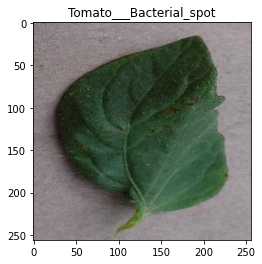

In [123]:
plt.imshow(plt.imread("../input/tomato/New Plant Diseases Dataset(Augmented)/valid/Tomato___Bacterial_spot/014b58ae-091b-408a-ab4a-5a780cd1c3f3___GCREC_Bact.Sp 2971.JPG"))
plt.title('Tomato___Bacterial_spot')

Text(0.5, 1.0, 'Tomato___Early_blight')

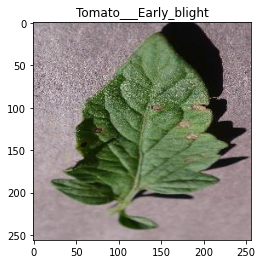

In [124]:
plt.imshow(plt.imread("../input/tomato/New Plant Diseases Dataset(Augmented)/valid/Tomato___Early_blight/01f87f04-ff38-4aba-b7d1-587aa06e5282___RS_Erly.B 7851.JPG"))
plt.title('Tomato___Early_blight')

Text(0.5, 1.0, 'Tomato___Late_blight')

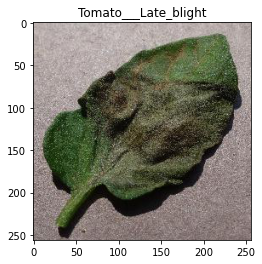

In [125]:
plt.imshow(plt.imread("../input/tomato/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/005a2c1f-4e15-49e4-9e5c-61dc3ecf9708___RS_Late.B 5096_flipLR.JPG"))
plt.title('Tomato___Late_blight')

Text(0.5, 1.0, 'Tomato___Leaf_Mold')

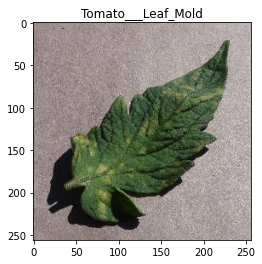

In [126]:
plt.imshow(plt.imread("../input/tomato/New Plant Diseases Dataset(Augmented)/valid/Tomato___Leaf_Mold/0160c3b5-d89e-40e5-a313-49ae1524040a___Crnl_L.Mold 6823.JPG"))
plt.title('Tomato___Leaf_Mold')

Text(0.5, 1.0, 'Tomato___Septoria_leaf_spot')

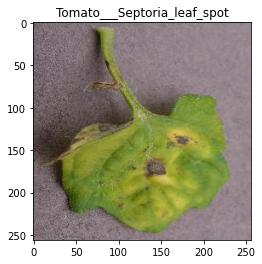

In [127]:
plt.imshow(plt.imread("../input/tomato/New Plant Diseases Dataset(Augmented)/valid/Tomato___Septoria_leaf_spot/03b3e88f-63ad-49e1-88c2-b8bfffd6aaf6___Matt.S_CG 1226_flipTB.JPG"))
plt.title('Tomato___Septoria_leaf_spot')

Text(0.5, 1.0, 'Tomato___Spider_mites Two-spotted_spider_mite')

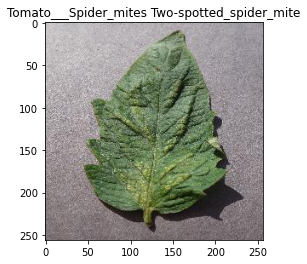

In [128]:
plt.imshow(plt.imread("../input/tomato/New Plant Diseases Dataset(Augmented)/valid/Tomato___Spider_mites Two-spotted_spider_mite/01854aac-d409-4136-b885-3df6943cc349___Com.G_SpM_FL 1374.JPG"))
plt.title('Tomato___Spider_mites Two-spotted_spider_mite')

Text(0.5, 1.0, 'Tomato___Target_Spot')

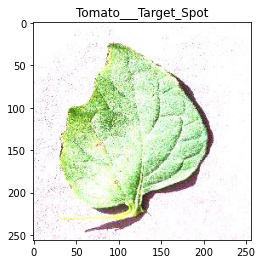

In [129]:
plt.imshow(plt.imread("../input/tomato/New Plant Diseases Dataset(Augmented)/valid/Tomato___Target_Spot/003a5321-0430-42dd-a38d-30ac4563f4ba___Com.G_TgS_FL 8121_newPixel25.JPG"))
plt.title('Tomato___Target_Spot')

Text(0.5, 1.0, 'Tomato_Yellow_Leaf_Curl_Virus')

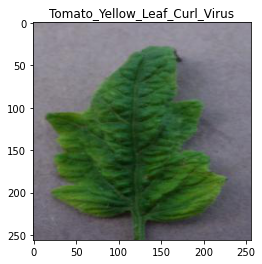

In [131]:
plt.imshow(plt.imread("../input/tomato/New Plant Diseases Dataset(Augmented)/valid/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0383249b-008c-4e0b-b8ee-7eae08be99d3___YLCV_GCREC 2722.JPG"))
plt.title('Tomato_Yellow_Leaf_Curl_Virus')

Text(0.5, 1.0, 'Tomato___mosaic_virus')

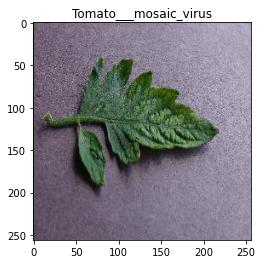

In [132]:
plt.imshow(plt.imread("../input/tomato/New Plant Diseases Dataset(Augmented)/valid/Tomato___Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169_270deg.JPG"))
plt.title('Tomato___mosaic_virus')

Text(0.5, 1.0, 'Tomato___healthy')

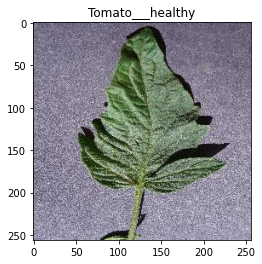

In [133]:
plt.imshow(plt.imread("../input/tomato/New Plant Diseases Dataset(Augmented)/valid/Tomato___healthy/014b5e19-7917-4d76-b632-b5dd31d999ec___RS_HL 9640.JPG"))
plt.title('Tomato___healthy')

## Check the Prediction for new data

In [98]:
# load the model
vgg_load = load_model('vgg_model.h5')

In [107]:
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR) # Reading the file
    img_array = img_array / 255
    new_array = cv2.resize(img_array, (224, 224)) # resizing the img_array to (224,224)
    return new_array.reshape(-1, 224, 224, 3) # reshaping the new data

model = tf.keras.models.load_model("vgg_model.h5")

### Prediction

In [111]:
prediction = model.predict([prepare("../input/tomato/New Plant Diseases Dataset(Augmented)/valid/Tomato___Tomato_Yellow_Leaf_Curl_Virus/057552a8-8c38-443f-b523-5ee2b428e622___UF.GRC_YLCV_Lab 09477.JPG")])
np.argmax(prediction)

7

In [112]:
class_dict = training_set.class_indices
class_dict

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

In [113]:
if np.argmax(prediction) == 0:
    print("Tomato___Bacterial_spot")
elif np.argmax(prediction) == 1:
    print("Tomato___Early_Blight")
elif np.argmax(prediction) == 2:
    print("Tomato___Late Blight")
elif np.argmax(prediction) == 3:
    print("Tomato___Leaf Mold")
elif np.argmax(prediction) == 4:
    print("Tomato___Septoria Leaf Spot")
elif np.argmax(prediction) == 5:
    print("Tomato___Spider mites")
elif np.argmax(prediction) == 6:
    print("Tomato___Target Spot")
elif np.argmax(prediction) == 7:
    print("Tomato___Yellow Leaf Curl Virus")
elif np.argmax(prediction) == 8:
    print("Tomato___Mosaic Virus")
else:
    print("Tomato___Healthy")

Tomato___Yellow Leaf Curl Virus


#### As we can see above the model has predict correct new data which is Tomato___Yellow Leaf Curl Virus

**If you like my Kernel Please Upvote !  Happy Learning :)**